<a href="https://colab.research.google.com/github/ckirby04/UArk-Projects/blob/Segmentation/Segmentation_PADIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install anomalib[full]

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.3/224.3 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.1/661.1 kB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 63.3 MB/s eta 0:00:

In [ ]:
from anomalib.data import MVTecAD
from anomalib.models.image.padim import Padim
from anomalib.engine import Engine

/usr/local/lib/python3.11/dist-packages/openvino/runtime/__init__.py:10: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
# Initialize model and data
datamodule = MVTecAD()
model = Padim(
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
    pre_trained=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [ ]:
# Train using the Engine
engine = Engine()
engine.fit(model=model, datamodule=datamodule)

INFO:lightning_fabric.utilities.rank_zero:GPU available: False, used: False
INFO:lightning_fabric.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:lightning_fabric.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:lightning_fabric.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
mvtecad: 5.26GB [02:40, 32.8MB/s]                            
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
INFO: 
  | Name           | Type          | Params | Mode 
---------------------------------------------------------
0 | pre_processor  | PreProcessor  | 0      | train
1 | post_processor | PostProcessor | 0      | train
2 | evaluator      | Evaluator     | 0      | train
3 | model          | PadimModel    | 2.8 M  | train
------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# Get predictions
predictions = engine.predict(model=model, datamodule=datamodule)

INFO:lightning_fabric.utilities.rank_zero:The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import torch

def show_anomaly_result(batch_item, threshold=0.5):
    image = batch_item.image[0].permute(1, 2, 0).cpu().numpy()  # CHW -> HWC
    anomaly_map = batch_item.pred_mask[0].cpu().numpy()
    binary_mask = (anomaly_map > threshold).astype(float)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(anomaly_map, cmap="jet")
    ax[1].set_title("Anomaly Map")
    ax[1].axis("off")

    ax[2].imshow(image)
    ax[2].imshow(binary_mask, cmap="jet", alpha=0.5)
    ax[2].set_title("Overlay")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

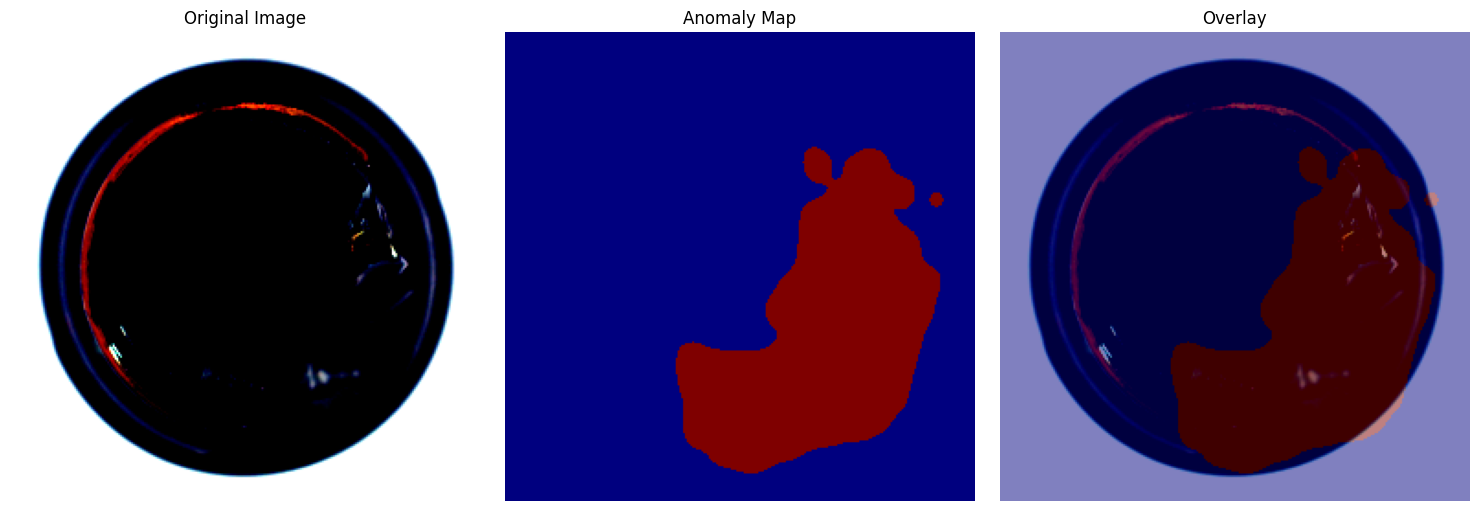

In [ ]:
show_anomaly_result(predictions[0])  # Show the first prediction

In [ ]:
import torch
import numpy as np
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

def evaluate_segmentation(predictions, threshold=0.5):
    iou_list, dice_list, acc_list = [], [], []

    for item in predictions:
        # Get predicted and true masks
        pred = item.pred_mask[0].cpu().numpy()
        true = item.gt_mask[0].cpu().numpy()

        # Binarize prediction
        pred_bin = (pred > threshold).astype(np.uint8)
        true_bin = (true > 0).astype(np.uint8)

        # Flatten for sklearn
        pred_flat = pred_bin.flatten()
        true_flat = true_bin.flatten()

        # Compute metrics
        iou = jaccard_score(true_flat, pred_flat)
        dice = f1_score(true_flat, pred_flat)
        acc = accuracy_score(true_flat, pred_flat)

        iou_list.append(iou)
        dice_list.append(dice)
        acc_list.append(acc)

    print(f"Mean Dice: {np.mean(dice_list):.4f}")
    print(f"Mean Acc:  {np.mean(acc_list):.4f}")


In [ ]:
evaluate_segmentation(predictions)

Mean Dice: 0.4725
Mean Acc:  0.9586


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
